In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


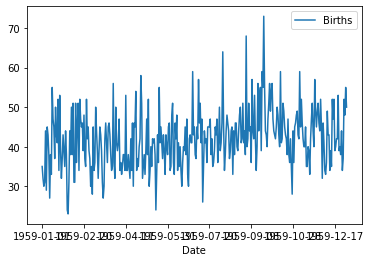

In [14]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
print(series.head())
series.plot()
pyplot.show()

In [2]:
series

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [3]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

In [4]:
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

In [5]:
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

In [6]:
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

In [8]:
test

array([-10,   3,  -6,  30, -28,   2,   9,  -7,   1,  -9,  21, -13,  -2,
        11, -11,  -8,   6,  16, -12,   9,   2, -16,  20,  -4,  18, -18,
       -11,  -1,  -3,   7,   4,   5,  -7,   5,   2,  -9,  -3,  -1,  -1,
         3,   5,  -2,  -5,  -3,  19, -18,   1,   9,  -2,  -4,  -2,  -1,
        -4,   9,  -9,  -2,   6,  -7,  -7,  16,  -8,   9,   1,   2,   1,
        -6,  -1,  17, -14,   7,  -6,  -4,  -2,   0,   5, -10,   0,   5,
        -1,  -6,   9,   5,   4,  -7,  -4,  17,  -8,  -4,   4,   2,  -5,
        -2,   8,  -7, -13,  14,  -5,  -7,  -1,   3,  13,  -6,   0,  -9,
         5,  -4,  17,  -5,   5, -13,   1,   2,   0,  11, -14,   1,  -2,
         6, -10,   3,  15,  -4,   7,  -5], dtype=int64)

In [9]:
# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params
coef

array([ 0.16061001, -0.76616332, -0.63670616, -0.55537201, -0.45887026,
       -0.32989392, -0.19056962])

In [10]:
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)

In [12]:
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7.259198873935887

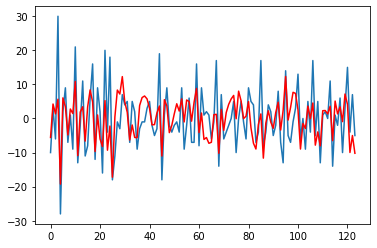

In [13]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# ARIMA

In [16]:
dfb_data = series
dfb_data.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


<AxesSubplot:xlabel='Date'>

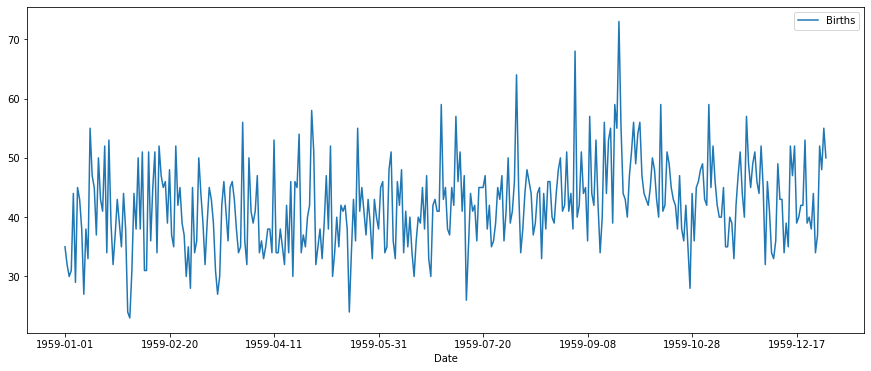

In [19]:
dfb_data.Births = dfb_data.Births.astype('float')
dfb_data.plot(figsize=(15,6))

In [20]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(dfb_data.Births)

print(f'ADF statistics : {results[0]}')
print(f'p-value : {results[1]}')
print(f'Critical Values : {results[4]}')

ADF statistics : -4.808291253559765
p-value : 5.2434129901498554e-05
Critical Values : {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}


In [21]:
results[1] <= 0.05 #The data is stationary

True

C:\Users\shubendu.biswas\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


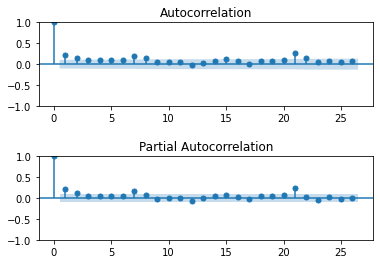

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure()
fig.subplots_adjust(hspace=0.6)
plt.subplot(211)
plot_acf(dfb_data.Births, ax=plt.gca()) # gca -> "GetCurrentAxis"
# Plots lags on the horizontal and the correlations on vertical axis.

plt.subplot(212)
plot_pacf(dfb_data.Births, ax=plt.gca())
plt.show();

In [27]:
import statsmodels.api as sm

train_size = int(len(dfb_data.Births) * 0.80)
train, test = dfb_data.Births[0:train_size], dfb_data.Births[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()
    predictions.append(yhat[0])
    obs = test[i]
    history.append(obs)

In [28]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE : {rmse}')

RMSE : 6.733170311497578
